In [2]:
import pandas as pd
import numpy as np
import random as rd
from cache import Cache

cache=Cache()

In [10]:
df = cache.load('clean_df_complete')

In [7]:
df['title_len'] = df['title'].apply(lambda x : len(x))
df['description_len'] = df['description'].apply(lambda x : len(x))
df['content_len'] = df['content'].apply(lambda x : len(x))

In [8]:
from statistics import mean 
print('mean title : ',mean(df['title_len']),
'\nmean description : ',mean(df['description_len']),
'\nmean content : ',mean(df['content_len']))

print('\nratio : ',mean(df['content_len'])/mean(df['description_len']),' and ',mean(df['content_len'])/mean(df['title_len']))

mean title :  41.92821651227684 
mean description :  156.9825001815334 
mean content :  2638.949834545285

ratio :  16.81047143148837  and  62.939711107735384


# Building training and testing data

In [61]:
labels  = cache.load('labels_96k')
content_lsa = cache.load('feature_content_lsa_96k')
description_lsa = cache.load('feature_description_lsa_96k')
title_lsa = cache.load('feature_title_lsa_96k')
content_w2v = cache.load('feature_content_w2v_96k')
title_w2v = cache.load('feature_title_w2v_96k')
description_w2v = cache.load('feature_description_w2v_96k')


title_flair = cache.load('features_embedding_titles_diversified')

In [65]:
XY = []
for i in range(len(labels)):
    temp = [item for item in np.concatenate((content_lsa[i],description_lsa[i],title_lsa[i],content_w2v[i],title_w2v[i],description_w2v[i],title_flair[i],labels['thematic_value'][i]),axis=None)]
    if len(temp)==412:
        XY+=[temp]
XY = np.array(XY)

In [66]:
XY.shape

(95495, 412)

In [68]:
np.random.seed(10000)
np.random.shuffle(XY)

X = XY[:,:-1]
Y = XY[:,-1]

In [69]:
split = (len(X)*8)//10

X_train = X[:split,:]
X_test = X[split+1:,:]
Y_train = Y[:split]
Y_test = Y[split+1:]

# Random forest

In [9]:
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import RandomForestClassifier as rfc

from sklearn.ensemble import RandomForestClassifier as rfc

class Forest():
    def __init__(self, n_estimators, max_depth, labels):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.labels = labels #liste de str
        self.n_labels = len(self.labels)
    
    def init_family_of_forests(self):
        classifiers = {}
        for label in self.labels:
            classifiers[label] = rfc(n_estimators=self.n_estimators, max_depth=self.max_depth,random_state=0)
        self.forests = classifiers
    
    def fit_forests(self, X, Y_dict, percentage):
        X_train = X[int(len(X)*percentage):]
        for label in self.labels:
            Y_train = Y_dict[label][int(len(Y_dict[label])*percentage):]
            self.forests[label].fit(X_train,Y_train)
            print('classifier ' + str(label) + ' trained')
            # attention le vecteur Y doit être un vecteur de 1 ou de 0 de taille len(X)
    def predict_proba(self,X):
        proba = {}
        for label in self.labels:
            proba[label] = self.forests[label].predict_proba(X).transpose()[0]
        proba = np.array([proba[label] for label in self.labels]).T
        
        return proba
    
    def softmax(proba):
        return (np.exp(proba.T) / np.sum(np.exp(proba.T), axis=0)).T
    
    # retourne la classe avec la plus forte probabilité
    
    def predict(self,X):
        pred = []
        for array in X:
            l = list(self.predict_proba(array))
            i = l.index(max(l)) + 1
            pred.append(i)
        return np.array(pred)
        
        
        

In [3]:
forest = rfc(n_estimators=200, max_depth=5,random_state=0)
forest.fit(X_train, Y_train)
forest.score(X_test, Y_test)

NameError: name 'X_train' is not defined

In [ ]:
f = forest(200, 15, [i for i in range(11)])

In [ ]:
f.init_family_of_forests()
f.fit_forests(X=X, Y_dict=dict_label, percentage=0.8)

In [ ]:
a = f.predict_proba(X_titles[int(len(X_titles)*0.8):])

In [14]:
forests = {}
scores = []
for i in range(11):
    
    Y_train_temp = np.array([int(item==i) for item in Y_train])
    Y_test_temp = np.array([int(item==i) for item in Y_test])
    
    
    forests[i] = rfc(n_estimators=200, max_depth=5,random_state=0)
    forests[i].fit(X_train, Y_train_temp)
    scores.append(forests[i].score(X_test, Y_test_temp))
    print('le score pour la classe ' + str(i) + ' est de ' + str(scores[i]) + ' %')

cache.save(forests,'forests_try2')

le score pour la classe 0 est de 0.9042831710126715 %
le score pour la classe 1 est de 0.8988899361189653 %
le score pour la classe 2 est de 0.9369567493978427 %
le score pour la classe 3 est de 0.8756937899256466 %
le score pour la classe 4 est de 0.9104094669598911 %
le score pour la classe 5 est de 0.9224526128390408 %
le score pour la classe 6 est de 0.9317205990156038 %
le score pour la classe 7 est de 0.9360142423290397 %
le score pour la classe 8 est de 0.9582678814535553 %
le score pour la classe 9 est de 0.9452822285056027 %
le score pour la classe 10 est de 0.9451775054979579 %


In [11]:
i= 0
d = {}
for word in df.thematic.unique():
    d[word] = i
    i+=1

label = df.thematic.apply(lambda x: d[x])
# dataframe avec les labels convertis en chiffres

dict_label = {}
for i in range(1,12):
    dict_label[i] = []
    for value in label:
        dict_label[i].append(int(value == i))

Y_label = np.array([dict_label[i] for i in range(1,12)])
# one-hot encoding das labels dans un array

In [40]:
classes = []
for i in range(11):
    classes.append(forests[i].predict(X_test))

classes = np.array(classes).T

In [46]:
test=[]
for item in classes:
    test.append(sum(item))

In [56]:
np.mean(test)

0.1845219394701016

# Keras NN

In [39]:
import tensorflow
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import activations
from tensorflow.keras.callbacks import TensorBoard
import time
from time import clock
from tensorflow.keras.utils import normalize, to_categorical
import pandas as pd
from keras.utils import to_categorical

C:\Users\auges\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [41]:
Y_cat = to_categorical(Y)
Y_train_cat = Y_cat[:split,:]
Y_test_cat = Y_cat[split+1:,:]


In [49]:
from vis.visualization import visualize_activation
from vis.utils import utils
import matplotlib.pyplot as plt

In [52]:
name=f'project-{int(time.time())}'


model=Sequential()

model.add(Dense(32, activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(256,activation='relu'))

model.add(Dense(11,activation='softmax'))

ada = keras.optimizers.Adagrad()

model.compile(loss='categorical_crossentropy',
              optimizer=ada,
              metrics=["accuracy"])

class_weights = {i:len(Y_train)/(sum(np.array([int(item==i) for item in Y_train]))*11) for i in range(11)}

history = model.fit(X_train, Y_train_cat, batch_size=32, epochs=200, validation_data=(X_test, Y_test_cat),class_weight = class_weights)

Train on 76396 samples, validate on 19098 samples
Epoch 1/200
76396/76396 [==============================] - 5s 59us/step - loss: 1.2433 - acc: 0.5812 - val_loss: 1.1406 - val_acc: 0.5896
Epoch 2/200
76396/76396 [==============================] - 4s 48us/step - loss: 1.1455 - acc: 0.6101 - val_loss: 1.1047 - val_acc: 0.6057
Epoch 3/200
76396/76396 [==============================] - 4s 46us/step - loss: 1.1206 - acc: 0.6181 - val_loss: 1.0747 - val_acc: 0.6221
Epoch 4/200
76396/76396 [==============================] - 4s 46us/step - loss: 1.1044 - acc: 0.6227 - val_loss: 1.0902 - val_acc: 0.6128
Epoch 5/200
76396/76396 [==============================] - 4s 50us/step - loss: 1.0938 - acc: 0.6258 - val_loss: 1.0761 - val_acc: 0.6204
Epoch 6/200
76396/76396 [==============================] - 4s 47us/step - loss: 1.0858 - acc: 0.6295 - val_loss: 1.0505 - val_acc: 0.6292
Epoch 7/200
76396/76396 [==============================] - 4s 46us/step - loss: 1.0782 - acc: 0.6326 - val_loss: 1.0536 - 

76396/76396 [==============================] - 4s 49us/step - loss: 0.9797 - acc: 0.6633 - val_loss: 0.9816 - val_acc: 0.6560
Epoch 60/200
76396/76396 [==============================] - 4s 51us/step - loss: 0.9787 - acc: 0.6642 - val_loss: 0.9856 - val_acc: 0.6552
Epoch 61/200
76396/76396 [==============================] - 4s 54us/step - loss: 0.9779 - acc: 0.6644 - val_loss: 0.9838 - val_acc: 0.6539
Epoch 62/200
76396/76396 [==============================] - 4s 52us/step - loss: 0.9771 - acc: 0.6652 - val_loss: 0.9774 - val_acc: 0.6565
Epoch 63/200
76396/76396 [==============================] - 4s 57us/step - loss: 0.9763 - acc: 0.6653 - val_loss: 0.9783 - val_acc: 0.6548
Epoch 64/200
76396/76396 [==============================] - 4s 57us/step - loss: 0.9755 - acc: 0.6656 - val_loss: 0.9857 - val_acc: 0.6514
Epoch 65/200
76396/76396 [==============================] - 4s 54us/step - loss: 0.9750 - acc: 0.6660 - val_loss: 0.9782 - val_acc: 0.6563
Epoch 66/200
76396/76396 [==============

Epoch 118/200
76396/76396 [==============================] - 4s 50us/step - loss: 0.9435 - acc: 0.6768 - val_loss: 0.9719 - val_acc: 0.6594
Epoch 119/200
76396/76396 [==============================] - 4s 50us/step - loss: 0.9430 - acc: 0.6775 - val_loss: 0.9741 - val_acc: 0.6596
Epoch 120/200
76396/76396 [==============================] - 4s 50us/step - loss: 0.9424 - acc: 0.6772 - val_loss: 0.9619 - val_acc: 0.6621
Epoch 121/200
76396/76396 [==============================] - 4s 50us/step - loss: 0.9419 - acc: 0.6768 - val_loss: 0.9650 - val_acc: 0.6622
Epoch 122/200
76396/76396 [==============================] - 4s 48us/step - loss: 0.9414 - acc: 0.6766 - val_loss: 0.9651 - val_acc: 0.6619
Epoch 123/200
76396/76396 [==============================] - 4s 49us/step - loss: 0.9408 - acc: 0.6774 - val_loss: 0.9639 - val_acc: 0.6626
Epoch 124/200
76396/76396 [==============================] - 4s 52us/step - loss: 0.9404 - acc: 0.6771 - val_loss: 0.9587 - val_acc: 0.6634
Epoch 125/200
76396/

76396/76396 [==============================] - 5s 60us/step - loss: 0.9202 - acc: 0.6838 - val_loss: 0.9595 - val_acc: 0.6644
Epoch 177/200
76396/76396 [==============================] - 5s 60us/step - loss: 0.9198 - acc: 0.6841 - val_loss: 0.9553 - val_acc: 0.6653
Epoch 178/200
76396/76396 [==============================] - 4s 53us/step - loss: 0.9196 - acc: 0.6848 - val_loss: 0.9600 - val_acc: 0.6649
Epoch 179/200
76396/76396 [==============================] - 4s 50us/step - loss: 0.9192 - acc: 0.6843 - val_loss: 0.9635 - val_acc: 0.6609
Epoch 180/200
76396/76396 [==============================] - 4s 50us/step - loss: 0.9189 - acc: 0.6852 - val_loss: 0.9594 - val_acc: 0.6647
Epoch 181/200
76396/76396 [==============================] - 4s 50us/step - loss: 0.9187 - acc: 0.6845 - val_loss: 0.9584 - val_acc: 0.6648
Epoch 182/200
76396/76396 [==============================] - 4s 53us/step - loss: 0.9184 - acc: 0.6844 - val_loss: 0.9582 - val_acc: 0.6673
Epoch 183/200
76396/76396 [=======

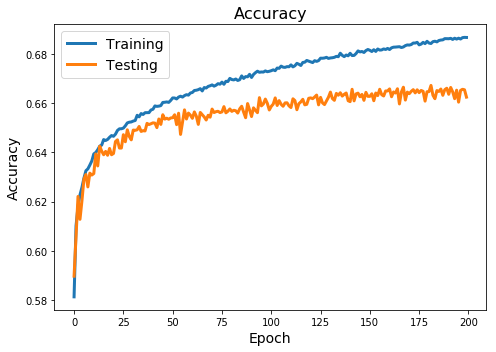

In [53]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['acc'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_acc'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

In [70]:
X_train.shape

(76396, 411)

In [71]:
X_train2 = X_train[:,-300:]
X_test2 = X_test[:,-300:]

In [74]:
model2=Sequential()

model2.add(Dense(32, activation='relu'))
model2.add(Dense(256,activation='relu'))
model2.add(Dense(256,activation='relu'))

model2.add(Dense(11,activation='softmax'))

ada = keras.optimizers.Adagrad()

model2.compile(loss='categorical_crossentropy',
              optimizer=ada,
              metrics=["accuracy"])

class_weights = {i:len(Y_train)/(sum(np.array([int(item==i) for item in Y_train]))*11) for i in range(11)}

history2 = model2.fit(X_train2, Y_train_cat, batch_size=32, epochs=200, validation_data=(X_test2, Y_test_cat),class_weight = class_weights)

Train on 76396 samples, validate on 19098 samples
Epoch 1/200
76396/76396 [==============================] - 5s 62us/step - loss: 1.2718 - acc: 0.6011 - val_loss: 1.1321 - val_acc: 0.6389
Epoch 2/200
76396/76396 [==============================] - 4s 55us/step - loss: 1.1244 - acc: 0.6498 - val_loss: 1.0816 - val_acc: 0.6590
Epoch 3/200
76396/76396 [==============================] - 4s 57us/step - loss: 1.0903 - acc: 0.6594 - val_loss: 1.0578 - val_acc: 0.6657
Epoch 4/200
76396/76396 [==============================] - 4s 56us/step - loss: 1.0703 - acc: 0.6649 - val_loss: 1.0544 - val_acc: 0.6663
Epoch 5/200
76396/76396 [==============================] - 4s 53us/step - loss: 1.0557 - acc: 0.6678 - val_loss: 1.0574 - val_acc: 0.6654
Epoch 6/200
76396/76396 [==============================] - 4s 53us/step - loss: 1.0451 - acc: 0.6717 - val_loss: 1.0501 - val_acc: 0.6639
Epoch 7/200
76396/76396 [==============================] - 5s 61us/step - loss: 1.0361 - acc: 0.6741 - val_loss: 1.0266 - 

76396/76396 [==============================] - 5s 64us/step - loss: 0.9300 - acc: 0.7007 - val_loss: 1.0002 - val_acc: 0.6792
Epoch 60/200
76396/76396 [==============================] - 5s 61us/step - loss: 0.9293 - acc: 0.7005 - val_loss: 0.9949 - val_acc: 0.6793
Epoch 61/200
76396/76396 [==============================] - 5s 60us/step - loss: 0.9288 - acc: 0.7007 - val_loss: 0.9975 - val_acc: 0.6788
Epoch 62/200
76396/76396 [==============================] - 5s 62us/step - loss: 0.9281 - acc: 0.7005 - val_loss: 0.9936 - val_acc: 0.6790
Epoch 63/200
76396/76396 [==============================] - 4s 59us/step - loss: 0.9270 - acc: 0.7010 - val_loss: 0.9934 - val_acc: 0.6798
Epoch 64/200
76396/76396 [==============================] - 4s 58us/step - loss: 0.9263 - acc: 0.7016 - val_loss: 0.9979 - val_acc: 0.6773
Epoch 65/200
76396/76396 [==============================] - 4s 56us/step - loss: 0.9256 - acc: 0.7014 - val_loss: 0.9928 - val_acc: 0.6802
Epoch 66/200
76396/76396 [==============

Epoch 118/200
76396/76396 [==============================] - 4s 56us/step - loss: 0.8938 - acc: 0.7093 - val_loss: 0.9940 - val_acc: 0.6815
Epoch 119/200
76396/76396 [==============================] - 4s 59us/step - loss: 0.8931 - acc: 0.7092 - val_loss: 0.9941 - val_acc: 0.6817
Epoch 120/200
76396/76396 [==============================] - 5s 61us/step - loss: 0.8926 - acc: 0.7094 - val_loss: 0.9932 - val_acc: 0.6816
Epoch 121/200
76396/76396 [==============================] - 5s 64us/step - loss: 0.8920 - acc: 0.7102 - val_loss: 0.9993 - val_acc: 0.6795
Epoch 122/200
76396/76396 [==============================] - 4s 58us/step - loss: 0.8918 - acc: 0.7100 - val_loss: 0.9929 - val_acc: 0.6825
Epoch 123/200
76396/76396 [==============================] - 4s 59us/step - loss: 0.8914 - acc: 0.7097 - val_loss: 0.9947 - val_acc: 0.6806
Epoch 124/200
76396/76396 [==============================] - 5s 60us/step - loss: 0.8908 - acc: 0.7104 - val_loss: 0.9974 - val_acc: 0.6803
Epoch 125/200
76396/

76396/76396 [==============================] - 5s 66us/step - loss: 0.8689 - acc: 0.7157 - val_loss: 0.9942 - val_acc: 0.6825
Epoch 177/200
76396/76396 [==============================] - 5s 62us/step - loss: 0.8685 - acc: 0.7160 - val_loss: 0.9995 - val_acc: 0.6794
Epoch 178/200
76396/76396 [==============================] - 4s 59us/step - loss: 0.8682 - acc: 0.7162 - val_loss: 0.9998 - val_acc: 0.6799
Epoch 179/200
76396/76396 [==============================] - 5s 60us/step - loss: 0.8677 - acc: 0.7160 - val_loss: 0.9988 - val_acc: 0.6808
Epoch 180/200
76396/76396 [==============================] - 5s 60us/step - loss: 0.8673 - acc: 0.7157 - val_loss: 0.9954 - val_acc: 0.6813
Epoch 181/200
76396/76396 [==============================] - 5s 65us/step - loss: 0.8671 - acc: 0.7163 - val_loss: 0.9937 - val_acc: 0.6826
Epoch 182/200
76396/76396 [==============================] - 5s 62us/step - loss: 0.8667 - acc: 0.7162 - val_loss: 0.9978 - val_acc: 0.6815
Epoch 183/200
76396/76396 [=======

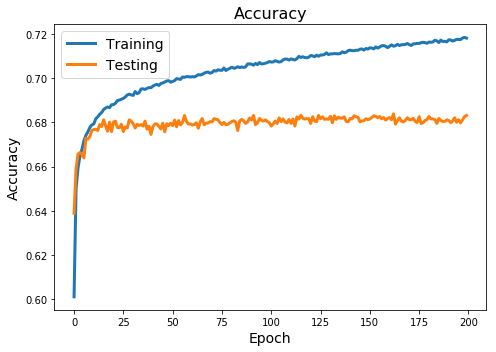

In [75]:
plt.figure(figsize=(7, 5))
plt.plot(history2.epoch, history2.history['acc'], lw=3, label='Training')
plt.plot(history2.epoch, history2.history['val_acc'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

In [57]:
df['subtitles'][0]

['« Nouveau contrat de confiance »', '« Processus électoral chaotique »']

In [60]:
np.unique(df['overall_theme'])

array(['"Projet Daphne"', 'A la une', 'Accès aux soins', 'Actu',
       'Addictions', 'Affaire Baupin', 'Affaire Fillon',
       'Affaire de la sextape de Valbuena', 'Affaire de logique',
       'Afrique', 'Aide', 'Al-Qaida', 'Alstom', 'Amériques',
       'Architecture', 'Archives', 'Archéologie', 'Argent & Placements',
       'Arts', 'Asie-Pacifique', 'Astronomie', 'Athlétisme',
       'Attentat de Berlin', 'Attentat de Manchester',
       'Attentats du 13-Novembre', 'Attentats en Catalogne', 'Auto-moto',
       'BTS et IUT', 'Bac', 'Bande dessinée', 'Banlieues', 'Basket',
       'Biodiversité', 'Biologie', 'Bioéthique', 'Bourse',
       'Brevet des collèges', 'Brexit', 'Brésil 2014',
       'Business of fashion', 'COP21', 'COP22', 'Charlottesville',
       'Chroniques', 'Cinéma', 'Cities', 'Climat',
       'Collection Musée idéal', 'Collection Mythologie', 'Comics',
       'Commémorations du 11-Novembre', 'Conférences climat',
       'Consommation', 'Contaminations', 'Corse', 'Coupe 

In [36]:
{i:sum(np.array([int(item==i) for item in Y_train])) for i in range(11)}

{0: 10945,
 1: 10777,
 2: 9555,
 3: 9023,
 4: 6724,
 5: 5614,
 6: 5395,
 7: 5006,
 8: 4813,
 9: 4178,
 10: 4366}

In [37]:
{i:len(Y_train)/(sum(np.array([int(item==i) for item in Y_train]))*11) for i in range(11)}

{0: 0.6345446239461772,
 1: 0.6444363838814985,
 2: 0.7268540982826697,
 3: 0.7697097316957674,
 4: 1.0328808609593856,
 5: 1.237102050069631,
 6: 1.287319909006656,
 7: 1.3873533577888353,
 8: 1.4429858527095178,
 9: 1.6623003611993559,
 10: 1.5907216924166077}

In [28]:
1/10945

9.136592051164915e-05

# Multi NN

In [62]:
NNs = {}
scores_NN = []
for i in range(11):
    
    Y_train_temp_cat = to_categorical(np.array([int(item==i) for item in Y_train]))
    Y_test_temp_cat = to_categorical(np.array([int(item==i) for item in Y_test]))
       
    
    NNs[i]=Sequential()

    NNs[i].add(Dense(32, activation='relu'))
    NNs[i].add(Dense(256,activation='relu'))
    NNs[i].add(Dense(256,activation='relu'))

    NNs[i].add(Dense(2,activation='softmax'))

    ada = keras.optimizers.Adagrad()

    NNs[i].compile(loss='categorical_crossentropy',
                  optimizer=ada,
                  metrics=["accuracy"])
    
    NNs[i].fit(X_train, Y_train_temp_cat, batch_size=32, epochs=10, validation_data=(X_test, Y_test_temp_cat),verbose=False)
    
    scores_NN.append(NNs[i].evaluate(X_test, Y_test_temp_cat,verbose=False))
    
    print('le score pour la classe ' + str(i) + ' est de \nloss : ' + str(scores_NN[i][0]) + '\naccuracy : ' + str(scores_NN[i][1]))

    
cache.save(NNs,'NNs_try1')

le score pour la classe 0 est de 
loss : 0.1386084643717598
accuracy : 0.9480573882144313
le score pour la classe 1 est de 
loss : 0.16030778272487267
accuracy : 0.9324536600379073
le score pour la classe 2 est de 
loss : 0.06823296725620448
accuracy : 0.9779558068907739
le score pour la classe 3 est de 
loss : 0.253130033551392
accuracy : 0.8916640485665076
le score pour la classe 4 est de 
loss : 0.20240175108726594
accuracy : 0.9130275421572526
le score pour la classe 5 est de 
loss : 0.11758523452326738
accuracy : 0.9587914964917792
le score pour la classe 6 est de 
loss : 0.17298617058188107
accuracy : 0.9365378573672636
le score pour la classe 7 est de 
loss : 0.1517144234246116
accuracy : 0.9416692847480997
le score pour la classe 8 est de 
loss : 0.05515359155784956
accuracy : 0.9799455439985728
le score pour la classe 9 est de 
loss : 0.11919058477183214
accuracy : 0.9537124305835556
le score pour la classe 10 est de 
loss : 0.13042612653781585
accuracy : 0.9529793695300421


In [87]:
probas_NN = []
for i in range(11):
    probas_NN.append(NNs[i].predict(X_test)[:,1])

probas_NN = np.array(probas_NN).T

In [90]:
probas_NN[0]

array([0.12311041, 0.00144824, 0.03539392, 0.29005042, 0.21916789,
       0.01995905, 0.03099126, 0.07595886, 0.00081773, 0.0317897 ,
       0.04784445], dtype=float32)

In [91]:
classes_NN = np.array([np.argmax(probas_NN[i]) for i in range(len(probas_NN))])

In [94]:
sum(classes_NN == Y_test)/len(Y_test)

0.6616923238035396

In [78]:
NNs2 = {}
scores_NN2 = []
for i in range(11):
    
    Y_train_temp_cat = to_categorical(np.array([int(item==i) for item in Y_train]))
    Y_test_temp_cat = to_categorical(np.array([int(item==i) for item in Y_test]))
       
    
    NNs2[i]=Sequential()

    NNs2[i].add(Dense(32, activation='relu'))
    NNs2[i].add(Dense(256,activation='relu'))
    NNs2[i].add(Dense(256,activation='relu'))

    NNs2[i].add(Dense(2,activation='softmax'))

    ada = keras.optimizers.Adagrad()

    NNs2[i].compile(loss='categorical_crossentropy',
                  optimizer=ada,
                  metrics=["accuracy"])
    
    NNs2[i].fit(X_train2, Y_train_temp_cat, batch_size=32, epochs=10, validation_data=(X_test2, Y_test_temp_cat),verbose=False)
    
    scores_NN2.append(NNs2[i].evaluate(X_test2, Y_test_temp_cat,verbose=False))
    
    print('le score pour la classe ' + str(i) + ' est de \nloss : ' + str(scores_NN2[i][0]) + '\naccuracy : ' + str(scores_NN2[i][1]))

    
cache.save(NNs2,'NNs_try3')

le score pour la classe 0 est de 
loss : 0.17278219389471036
accuracy : 0.9332390826014851
le score pour la classe 1 est de 
loss : 0.20394753312138267
accuracy : 0.921667190250495
le score pour la classe 2 est de 
loss : 0.08089678413313163
accuracy : 0.9755995391813145
le score pour la classe 3 est de 
loss : 0.18098444775946915
accuracy : 0.9333961671004684
le score pour la classe 4 est de 
loss : 0.19593260415325192
accuracy : 0.9243899884867112
le score pour la classe 5 est de 
loss : 0.1368346848120451
accuracy : 0.9558592522839674
le score pour la classe 6 est de 
loss : 0.16822193046187728
accuracy : 0.9389988480469159
le score pour la classe 7 est de 
loss : 0.11981606811787499
accuracy : 0.9579537123994111
le score pour la classe 8 est de 
loss : 0.08759987903533586
accuracy : 0.9715153418831681
le score pour la classe 9 est de 
loss : 0.1202464294989988
accuracy : 0.9574824588962195
le score pour la classe 10 est de 
loss : 0.11065030214140235
accuracy : 0.9606765105919334


In [79]:
probas_NN2 = []
for i in range(11):
    probas_NN2.append(NNs2[i].predict(X_test2)[:,1])

probas_NN2 = np.array(probas_NN2).T

In [80]:
classes_NN2 = np.array([np.argmax(probas_NN2[i]) for i in range(len(probas_NN2))])

In [81]:
sum(classes_NN2 == Y_test)/len(Y_test)

0.6948895172269347